## Prismatic Dislocation Loop and A Void

We use DD simulator [DDLab](http://micro.stanford.edu/~caiwei/Forum/2005-12-05-DDLab/) to generate data for this test case.

The source code for DDLab is in `scripts/Case03-PDL` folder.

**Please run `scripts/Case03-PDL/input_prism_z.m` first to generate data.**

### Prototype of the calculation

We first test our solution on one of the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spm
import pyshtools
import sys, time
sys.path.append('../module/')
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from SHUtil import SHCilmToVector, lmk2K, K2lmk
from SHBV import fast_stress_solution, generate_submat, print_SH_mode
from scipy.io import loadmat,savemat
from ShElastic import calSmode

In [2]:
Smatfile = '../scripts/Case03-PDL/data_PDL/Susrs_z0.67000_ab400.mat'

data = loadmat(Smatfile)
T_usr_mesh = np.swapaxes(data['Tusr'],0,1).astype(np.complex)
print(T_usr_mesh.shape)

(81, 41, 3, 3)


In [3]:
Xgrid = np.swapaxes(data['Xgrid'],0,1)
r0 = np.sqrt(np.sum(Xgrid**2, axis=-1)).mean()
N = -Xgrid/r0;
T_usr_mesh = np.sum(T_usr_mesh*N[...,np.newaxis,:], axis=-1)
print(r0)
# X = Xgrid[...,0]; Y = Xgrid[...,1]; Z = Xgrid[...,2];

x = np.vstack([data['rn'][:, :3], data['rn'][0, :3]])
xm = (x[1:,:]+x[:-1,:])/2
xi = x[1:,:] - x[:-1,:]
norm_xi = np.linalg.norm(xi, axis=1)
xi = xi/norm_xi[:, np.newaxis]
print(xm.shape, xi.shape)

x = x[:-1,:]
b0 = data['burg']
#print(b0)

1.0
(50, 3) (50, 3)


load the image stress problem setting
generate meshing on the void surface
lJmax = 40 lKmax = 37


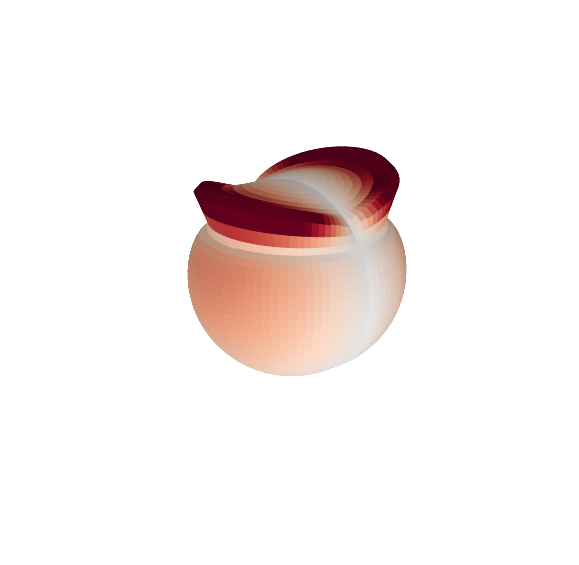

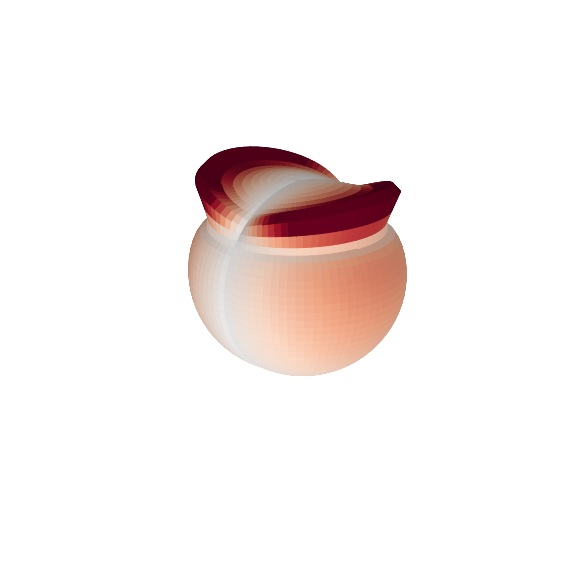

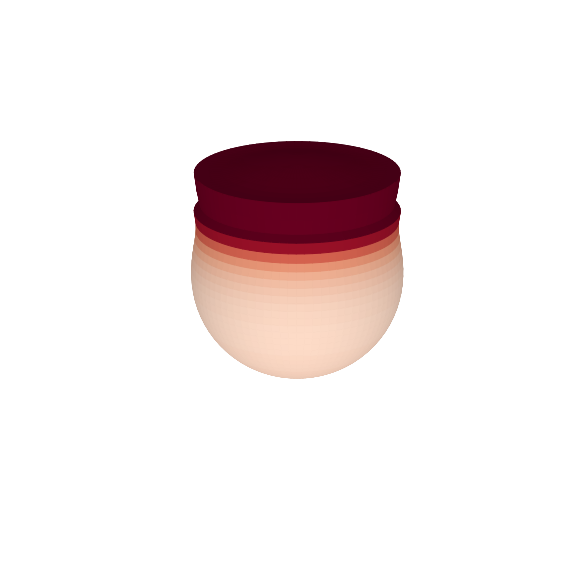

decompose traction boundary condition 4.695631742477417


In [4]:
mu = 1.0; nu = 1./3;

a = r0/r0; b1 = b0/r0; x1 = x/r0;
b = np.linalg.norm(b1, axis=1).mean()
print('load the image stress problem setting')

#### generate meshing on the void surface
# R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
print('generate meshing on the void surface')

#### decompose traction boundary condition
tic = time.time()

T_usr_vec = np.array([])
lJmax = T_usr_mesh.shape[1] - 1
lKmax = lJmax - 3
#lJmax = 43; lKmax = 40;
print('lJmax =', lJmax, 'lKmax =', lKmax)
LJ = (lJmax+1)**2

mk = '*x.'
T_usr_vec = np.empty(3*LJ, dtype=np.complex)
for k in range(3):
    T_usr_grid = pyshtools.SHGrid.from_array(T_usr_mesh[...,k].T, grid='GLQ')
    T_usr_grid.plot3d(azimuth=45, elevation=20)
    T_usr_cilm = T_usr_grid.expand(lmax_calc=lJmax)
    T_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)
toc = time.time()
print('decompose traction boundary condition', toc-tic)

In [5]:
#### load traction mode matrix
tic = time.time()

shtype = 'irr'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)

toc = time.time()
print('load traction mode matrix', toc-tic)

load traction mode matrix 0.08823657035827637


In [6]:
from scipy.sparse.linalg import lsqr

#### determine the mode coefficients
tic = time.time()
A = lsqr(Cmat, T_usr_vec.T)
toc = time.time()
A_sol = A[0]
print('Residual:', A[3])
index_sol = print_SH_mode(A_sol, m_dir=3, etol=1e-8,verbose=False)
print('determine the mode coefficients ( mode', len(index_sol), '):', toc-tic)

Residual: 0.00011734442998060056
determine the mode coefficients ( mode 186 ): 0.4759502410888672


In [7]:
#### reconstruct the traction boundary value on the surface
tic = time.time()
nseg, m = b1.shape

latglq, longlq = pyshtools.expand.GLQGridCoord(lJmax)
theta = np.deg2rad(90 - latglq)
phi = np.deg2rad(longlq)

Tp,Pp = np.meshgrid(theta, phi)
Rp = np.ones_like(Tp)
Xp, Yp, Zp = SphCoord_to_CartCoord(Rp, Tp, Pp)
Np = -np.stack((Xp/Rp, Yp/Rp, Zp/Rp), axis=-1)

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

sigma_tot = fast_stress_solution(A_sol, Xp,Yp,Zp, Smodes, lKmax, lJmax)

toc = time.time()
print(sigma_tot.shape, toc-tic)

(81, 41, 3, 3) 102.71319389343262


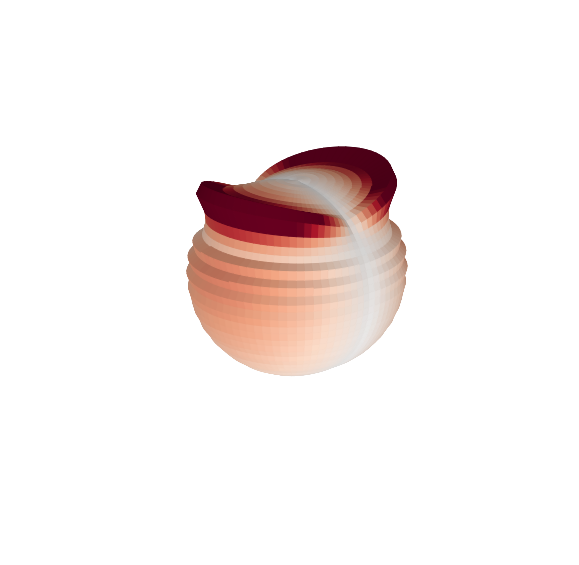

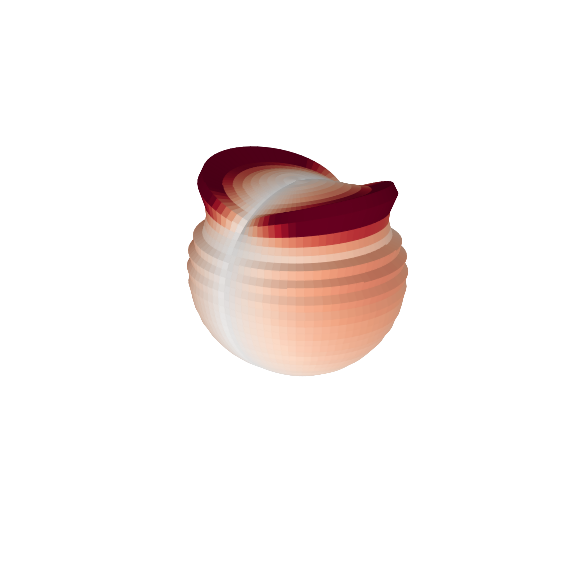

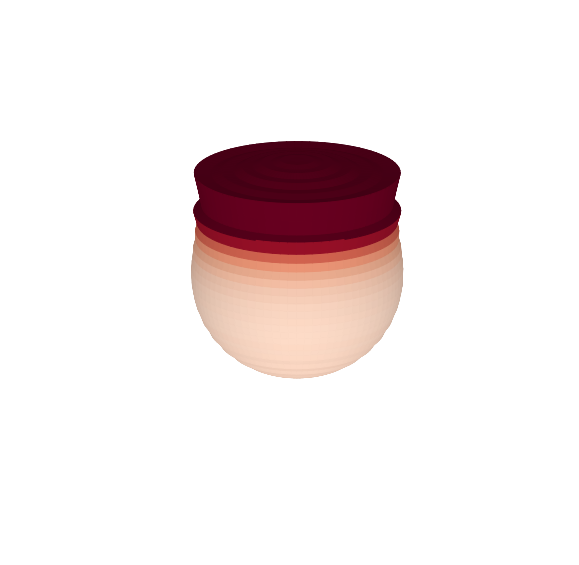

In [8]:
T_sol = np.sum(sigma_tot*Np[...,np.newaxis,:], axis=-1).astype(np.complex)

for k in range(3):
    T_sol_grid = pyshtools.SHGrid.from_array(T_sol[...,k].T, grid='GLQ')
    T_sol_grid.plot3d(elevation=20, azimuth=45)

In [9]:
#### evaluate the nodal force on the dislocation segments
nseg, m = b1.shape
#f1 = np.zeros(x1.shape)

Xseg = xm[:, 0]/r0; Yseg = xm[:, 1]/r0; Zseg = xm[:, 2]/r0;

Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, Xseg,Yseg,Zseg, Smodes, lKmax, lJmax)
toc = time.time()
print(sigma_tot.shape, toc-tic)

fimg = np.cross(np.sum(sigma_tot*b0[:,np.newaxis,:], axis=-1), xi)
print(fimg.shape)
print('f_glide =', fimg[:,2].mean()*r0/(b*r0)**2)

(50, 3, 3) 1.6790173053741455
(50, 3)
f_glide = -1.7879602654186288


In [10]:
# Elastic energy

from ShElastic import calUmode
from SHBV import fast_energy_solution

Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
Uvec = Dmat.dot(A_sol)

Eh=2*np.pi*np.vdot(Uvec, T_usr_vec)/r0/(b*r0)**2

print(Eh.real)

-0.7197618299037575


In [11]:
# Elastic energy stored in the core

shtype = 'reg'
Tcmodes = loadmat('Tmodes.mat')
Tcmodes = (Tcmodes['T1'+shtype], Tcmodes['T2'+shtype], Tcmodes['T3'+shtype], Tcmodes['T0'+shtype])
fullCcmat = calSmode(Tcmodes, mu, nu)
Ccmat = generate_submat(mu, nu, fullCcmat, lKmax, lJmax)

Ucmodes = loadmat('Umodes.mat')
Ucmodes = (Ucmodes['U1'+shtype], Ucmodes['U0'+shtype])
fullDcmat = calUmode(Ucmodes, mu, nu)
Dcmat = generate_submat(mu, nu, fullDcmat, lKmax, lJmax)

Ac = spm.linalg.lsqr(Ccmat, -T_usr_vec.T)
Ac_sol = Ac[0]

Ucvec = Dcmat.dot(Ac_sol)
Ec = 2*np.pi*np.vdot(Ucvec, T_usr_vec)/r0/(b*r0)**2

print(Ec.real+Eh.real)

-1.40065007034306


### Calculate the force for different loop location

In [12]:
def image_force(filename, mu=1.0, nu=1./3, lJmax=None, lKmax=None, Cmat=None, Dmat=None, Ccmat=None, Dcmat=None, Smodes=None, verbose=True, energy=False):
    # load the data file
    data = loadmat(filename)
    T_usr_mesh = np.swapaxes(data['Tusr'],0,1).astype(np.complex)
    Xgrid = np.swapaxes(data['Xgrid'],0,1)
    r0 = np.sqrt(np.sum(Xgrid**2, axis=-1)).mean(); N = -Xgrid/r0;
    T_usr_mesh = np.sum(T_usr_mesh*N[...,np.newaxis,:], axis=-1)
    x = np.vstack([data['rn'][:, :3], data['rn'][0, :3]])/r0
    xm = (x[1:,:]+x[:-1,:])/2
    xi = x[1:,:] - x[:-1,:]
    norm_xi = np.linalg.norm(xi, axis=1)
    xi = xi/norm_xi[:, np.newaxis]
    x = x[:-1,:]
    b0 = data['burg']

    a = r0/r0; b1 = b0/r0;
    b = np.linalg.norm(b1, axis=1).mean()
    if verbose:
        print('load the image stress problem setting')

    #### decompose traction boundary condition
    tic = time.time()

    T_usr_vec = np.array([])
    if lJmax is None:
        lJmax = T_usr_mesh.shape[1] - 1
        lKmax = lJmax - 3
    LJ = (lJmax+1)**2

    mk = '*x.'
    T_usr_vec = np.empty(3*LJ, dtype=np.complex)
    for k in range(3):
        T_usr_grid = pyshtools.SHGrid.from_array(T_usr_mesh[...,k].T, grid='GLQ')
        T_usr_cilm = T_usr_grid.expand(lmax_calc=lJmax)
        T_usr_vec[LJ*k:LJ*(k+1)] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)
    toc = time.time()
    if verbose:
        print('decompose traction boundary condition', toc-tic)
    
    #### load traction mode matrix
    tic = time.time()

    shtype = 'irr'
    if Cmat is None:
        Tmodes = loadmat('Tmodes.mat')
        Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
        fullCmat = calSmode(Tmodes, mu, nu)
        Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)
    if Dmat is not None:
        Umodes = loadmat('Umodes.mat')
        Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
        fullDmat = calUmode(Umodes, mu, nu)
        Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)

    toc = time.time()
    if verbose:
        print('load traction mode matrix', toc-tic)
    
    #### determine the mode coefficients
    tic = time.time()
    A = spm.linalg.lsqr(Cmat, T_usr_vec.T)
    toc = time.time()
    A_sol = A[0]
    index_sol = print_SH_mode(A_sol, m_dir=3, etol=1e-8,verbose=False)
    if verbose:
        print('determine the mode coefficients ( mode', len(index_sol), '):', toc-tic)
    
    #### evaluate the nodal force on the dislocation segments
    Xseg = xm[:, 0]; Yseg = xm[:, 1]; Zseg = xm[:, 2];

    if Smodes is None:
        Smodes = loadmat('Smodes.mat')
        Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
        fullSmodes = calSmode(Smodes, mu, nu)
        Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)

    tic = time.time()
    sigma_tot = fast_stress_solution(A_sol, Xseg,Yseg,Zseg, Smodes, lKmax, lJmax)
    toc = time.time()
    if verbose:
        print('evaluate image stress on the dislocation segments', sigma_tot.shape, toc-tic)

    fimg = np.cross(np.sum(sigma_tot*b0[:,np.newaxis,:], axis=-1), xi)
    # print(fimg.shape)
    if energy:
        if (Ccmat is not None) and (Dcmat is not None):
            Ac = spm.linalg.lsqr(Ccmat, -T_usr_vec.T)
            E_el = fast_energy_solution(A_sol, Dmat, Cmat, Ac_sol=Ac[0], Dcmat=Dcmat, Ccmat=Ccmat)
        else:
            E_el = fast_energy_solution(A_sol, Dmat, Cmat)
        return (fimg, E_el) #(fimg/r0*mu*(b*r0)**2, E_el*mu*r0*(b*r0)**2)
    else:
        return fimg

In [13]:
lJmax = 40
lKmax = 37

shtype = 'irr'
Tmodes = loadmat('Tmodes.mat')
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax)        
Smodes = loadmat('Smodes.mat')
Smodes = (Smodes['S1'+shtype], Smodes['S2'+shtype], Smodes['S3'+shtype], Smodes['S0'+shtype])
fullSmodes = calSmode(Smodes, mu, nu)
Smodes = generate_submat(mu, nu, fullSmodes, lKmax, lJmax, kJ=9)
Umodes = loadmat('Umodes.mat')
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax)

shtype = 'reg'
Tcmodes = loadmat('Tmodes.mat')
Tcmodes = (Tcmodes['T1'+shtype], Tcmodes['T2'+shtype], Tcmodes['T3'+shtype], Tcmodes['T0'+shtype])
fullCcmat = calSmode(Tcmodes, mu, nu)
Ccmat = generate_submat(mu, nu, fullCcmat, lKmax, lJmax)
Ucmodes = loadmat('Umodes.mat')
Ucmodes = (Ucmodes['U1'+shtype], Ucmodes['U0'+shtype])
fullDcmat = calUmode(Ucmodes, mu, nu)
Dcmat = generate_submat(mu, nu, fullDcmat, lKmax, lJmax)

a/b = 40 z = 0.67
a/b = 40 z = 0.7532500000000001
a/b = 40 z = 0.8365
a/b = 40 z = 0.9197500000000001
a/b = 40 z = 1.0030000000000001
a/b = 40 z = 1.0862500000000002
a/b = 40 z = 1.1695000000000002
a/b = 40 z = 1.25275
a/b = 40 z = 1.336
a/b = 40 z = 1.4192500000000001
a/b = 40 z = 1.5025
a/b = 40 z = 1.58575
a/b = 40 z = 1.669
a/b = 40 z = 1.75225
a/b = 40 z = 1.8355000000000001
a/b = 40 z = 1.9187500000000002
a/b = 40 z = 2.0020000000000002
a/b = 40 z = 2.0852500000000003
a/b = 40 z = 2.1685000000000003
a/b = 40 z = 2.25175
a/b = 40 z = 2.335
a/b = 40 z = 2.41825
a/b = 40 z = 2.5015
a/b = 40 z = 2.58475
a/b = 40 z = 2.668
a/b = 40 z = 2.75125
a/b = 40 z = 2.8345000000000002
a/b = 40 z = 2.91775
a/b = 40 z = 3.001
a/b = 40 z = 3.08425
a/b = 40 z = 3.1675
a/b = 40 z = 3.25075
a/b = 40 z = 3.334
a/b = 40 z = 3.41725
a/b = 40 z = 3.5005
a/b = 40 z = 3.58375
a/b = 40 z = 3.6670000000000003
a/b = 40 z = 3.7502500000000003
a/b = 40 z = 3.8335
a/b = 40 z = 3.91675
a/b = 40 z = 4.0


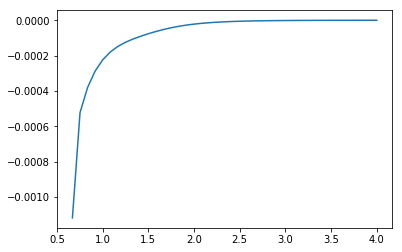

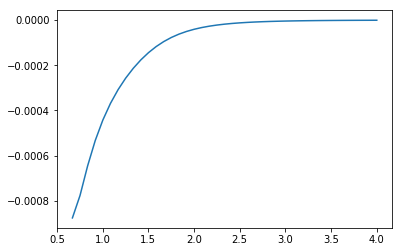

In [15]:
# small loop
fileinit = '../scripts/Case03-PDL/data_PDL/Susrs'
zlen = 41
a_b_list = [40,]# 200, 400, 4000, 40000]
z_list = np.linspace(0.67, 4.0, zlen)
matdict = {'z_list': z_list}

for ab in a_b_list:
    fz = np.empty_like(z_list)
    E = np.empty_like(z_list)
    for i in range(z_list.size):
        z0 = z_list[i]
        print('a/b =',ab,'z =',z0)
        filename = fileinit + '_z%.5f_ab%d.mat'%(z0, ab)
        fimg, E[i] = image_force(filename, lJmax=lJmax, lKmax=lKmax, Cmat=Cmat, Dmat=Dmat, Ccmat=Ccmat, Dcmat=Dcmat, Smodes=Smodes, verbose=False, energy=True)
        fz[i] = fimg[:, 2].mean()
    plt.figure(0)
    plt.plot(z_list, fz)
    plt.figure(1)
    plt.plot(z_list, E)
    matdict['fz_%d'%ab] = fz
    matdict['E_%d'%ab] = E
plt.show()

In [16]:
savemat('../figures/case3-result-small.mat', matdict)

In [17]:
# large loop
fileinit = '../scripts/Case03-PDL/data_PDL/Susrl'
#zlen = 51
#z_list = np.linspace(-4, 4, zlen)
z_list = np.hstack([np.arange(-4, -0.2, 0.2),\
                    np.arange(-0.2, 0.22, 0.04),\
                    np.arange(0.4, 4, 0.2)])
z_list[np.abs(z_list)<1e-8] = 0.0
ab = 40
tt = np.arange(np.pi/50, 2*np.pi, 2*np.pi/50)

fz = np.zeros_like(z_list)
fc = np.zeros_like(z_list)
E = np.zeros_like(z_list)
for i in range(z_list.size):
    z0 = z_list[i]
    print('a/b =',ab,'z =',z0)
    filename = fileinit + '_z%.5f_ab40.mat'%z0
    fimg, E[i] = image_force(filename, lJmax=lJmax, lKmax=lKmax, Cmat=Cmat, Dmat=Dmat, Ccmat=Ccmat, Dcmat=Dcmat, Smodes=Smodes, verbose=False, energy=True)
    fz[i] = fimg[:, 2].mean()
    fc[i] = np.mean(fimg[:, 0]*np.cos(tt) + fimg[:, 1]*np.sin(tt))

a/b = 40 z = -4.0
a/b = 40 z = -3.8
a/b = 40 z = -3.5999999999999996
a/b = 40 z = -3.3999999999999995
a/b = 40 z = -3.1999999999999993
a/b = 40 z = -2.999999999999999
a/b = 40 z = -2.799999999999999
a/b = 40 z = -2.5999999999999988
a/b = 40 z = -2.3999999999999986
a/b = 40 z = -2.1999999999999984
a/b = 40 z = -1.9999999999999982
a/b = 40 z = -1.799999999999998
a/b = 40 z = -1.5999999999999979
a/b = 40 z = -1.3999999999999977
a/b = 40 z = -1.1999999999999975
a/b = 40 z = -0.9999999999999973
a/b = 40 z = -0.7999999999999972
a/b = 40 z = -0.599999999999997
a/b = 40 z = -0.3999999999999968
a/b = 40 z = -0.2
a/b = 40 z = -0.16
a/b = 40 z = -0.12
a/b = 40 z = -0.07999999999999999
a/b = 40 z = -0.03999999999999998
a/b = 40 z = 0.0
a/b = 40 z = 0.040000000000000036
a/b = 40 z = 0.08000000000000002
a/b = 40 z = 0.12000000000000005
a/b = 40 z = 0.1600000000000001
a/b = 40 z = 0.20000000000000007
a/b = 40 z = 0.4
a/b = 40 z = 0.6000000000000001
a/b = 40 z = 0.8000000000000002
a/b = 40 z = 1.00000

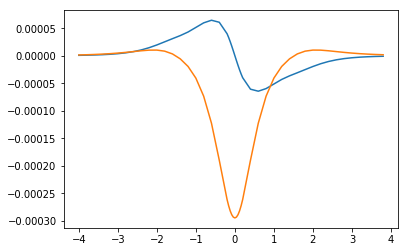

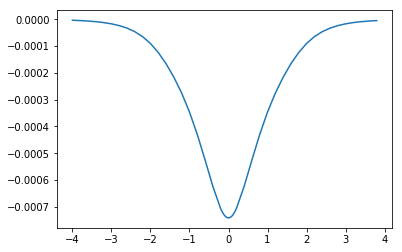

In [18]:
plt.figure(0)
plt.plot(z_list, fz, z_list, fc)
plt.figure(1)
plt.plot(z_list, E)
plt.show()

Numerically test whether the gradient of energy is actually the total force for large loop.

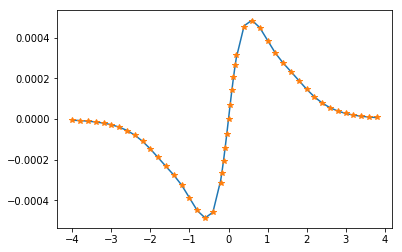

In [22]:
plt.plot(z_list, -fz*1.2*2*np.pi)
plt.plot(z_list, np.gradient(E, z_list), '*')
plt.show()

In [20]:
savemat('../figures/case3-result-large.mat', {'z_list': z_list, 'fg': fz, 'fc': fc, 'E': E})

Numerically test whether the gradient of energy is actually the total force for small loop.

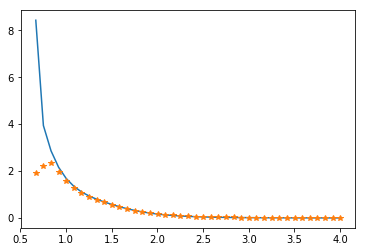

In [23]:
small_z = matdict['z_list']
small_f = matdict['fz_40']
small_E = matdict['E_40']
plt.plot(small_z, -small_f*40**2*.75*2*np.pi)
plt.plot(small_z, np.gradient(small_E*40**2, small_z), '*')
plt.show()